In [18]:
%pylab inline
from vplot import *
import pandas as pd
import os
import scipy.stats

# Which locus to use
CHROM=21
#START=16319166 # Figure example
START=15449764
OUTPATH="pdfs/"
PREFIX="Figure3"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec

Populating the interactive namespace from numpy and matplotlib


In [19]:
%%bash -s "$CHROM" "$START" 
CHROM=$1
START=$2
WINDOW=5000
VCF=/storage/s1saini/manuscript_strsnp/fig3/loo/chr${CHROM}.str.snp.vcf.gz

# Load true/imputed genotypes
grep $CHROM:$START /storage/s1saini/manuscript_strsnp/fig3/loo/*.diff.txt | \
    awk -F"/" '{print $NF}' | \
    sed 's/.diff.txt:${CHROM}:${START}//' > ssc_res.tab
    
# Get SNPs to use (only ones in LD with the STR)
#MINMAF=0.01, MINR2=0.01
/home/mgymrek/workspace/ssc-imputation/snpstr-ld/snp_str_ld_calculator.py \
  --str-vcf /storage/s1saini/hipstr_rerun/chr${CHROM}/hipstr.chr${CHROM}.with.1kg.filtered.vcf.gz \
  --snp-vcf /storage/resources/datasets/SSC_SNP_v2/shapeit.chr${CHROM}.with.ref.vcf.gz \
  --pairwise-snpstr \
  --region ${CHROM}:$START-$START \
  --max-dist $WINDOW | grep -v "nan" | grep -v locus2 | \
      awk '($5>=0.01 && $7>0.01) {print $2 }'| sed 's/:/\t/' | \
    awk '{print $1 "\t" $2-1 "\t" $2}' > snp_loci.bed

# Get allele-r2 to sort on later
/home/mgymrek/workspace/ssc-imputation/snpstr-ld/snp_str_ld_calculator.py \
  --str-vcf /storage/s1saini/hipstr_rerun/chr${CHROM}/hipstr.chr${CHROM}.with.1kg.filtered.vcf.gz \
  --snp-vcf /storage/resources/datasets/SSC_SNP_v2/shapeit.chr${CHROM}.with.ref.vcf.gz \
  --pairwise-snpstr --allele-r2 \
  --region ${CHROM}:$START-$START \
  --max-dist $WINDOW | grep -v "nan" > snp_loci_alleler2.tab
  
# Extract haplotypes
bcftools query -R snp_loci.bed \
     -f "%ID\t%POS\t%REF\t%ALT\t[%GT\t]\n" \
     $VCF | awk '(length($3)==1)' | sed 's/|/\t/g' > haplotypes.tab
bcftools query -r ${CHROM}:${START}-${START} \
    -f "%ID\t%POS\t%REF\t%ALT\t[%GT\t]\n" ${VCF} | \
    awk -v"start=$START" '($2==start)' | \
    sed 's/|/\t/g' >> haplotypes.tab

/usr/lib64/python2.7/site-packages/scipy/stats/stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/usr/lib64/python2.7/site-packages/scipy/stats/stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


(0.49770957198130883, 1.0443646305281232e-63)

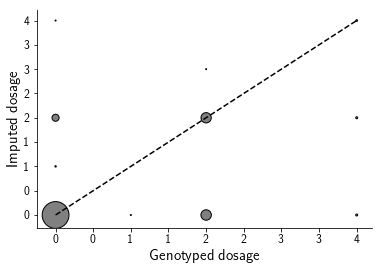

In [25]:
# Bubble plot
d = pd.read_csv("ssc_res.tab", sep=" ", names=["sample","true_1","true_2","impute_1","impute_2"], usecols=[0,1,2,4,5])
d["sum_true"] = d["true_1"]+d["true_2"]
d["sum_imp"] = d["impute_1"] + d["impute_2"]
bubbles = d.groupby(["sum_true","sum_imp"], as_index=False).agg({"sample": len})

# Bubble chart of obs vs. exp
minval=max([min(bubbles["sum_true"]),min(bubbles["sum_imp"])])
maxval=min([max(bubbles["sum_true"]),max(bubbles["sum_imp"])])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(bubbles["sum_true"], bubbles["sum_imp"], s=bubbles["sample"],
           color="gray", edgecolor="black", linewidth=1)
ax.plot([minval,maxval], [minval,maxval], color="black", linestyle="dashed")

# Plot legend
xvals = [minval+1]*3
yvals = [minval+i for i in range(3)]
sizes = [10, 100, 1000]
#ax.scatter(xvals, yvals, s=sizes, color="gray", edgecolor="black", linewidth=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Genotyped dosage", size=15)
ax.set_ylabel("Imputed dosage", size=15)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);

fig.savefig(os.path.join(OUTPATH, "%s_ExampleBubble.pdf"%PREFIX))
scipy.stats.pearsonr(d["sum_true"], d["sum_imp"])


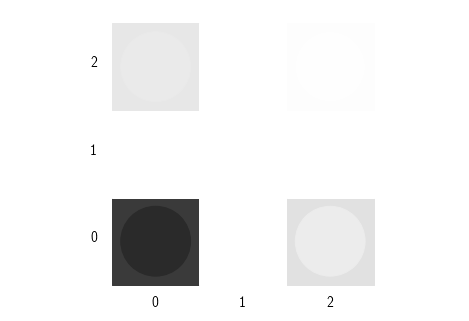

In [21]:
# Vasarely plot
true_gts, imputed_gts = GetTrueImpute(d)
Vasarely(imputed_gts, true_gts, os.path.join(OUTPATH, "%s_ExampleVasarely.pdf"%PREFIX))

In [22]:
# Read in haplotypes
numhaps = 1916*2
colnames = ["id","pos","ref","alt"] + ["hap_%s"%i for i in range(numhaps)]
haplotypes = pd.read_csv("haplotypes.tab", sep="\t",
                        names=colnames, usecols=range(len(colnames)))
haplotypes["vartype"] = haplotypes.apply(lambda x: ["SNP","STR"][int(len(x["ref"])>1)], 1)
haplotypes.index = ["pos"+str(haplotypes["pos"].values[i]) for i in range(haplotypes.shape[0]-1)] + ["STR"]

# Annotate STR lengths
ref = haplotypes[haplotypes["vartype"]=="STR"]["ref"].values[0]
alt = haplotypes[haplotypes["vartype"]=="STR"]["alt"].values[0].split(",")
str_allele_lengths = [len(ref)] + [len(item) for item in alt]
str_allele_lengths = [item-len(ref) for item in str_allele_lengths]
for i in range(numhaps):
    col = "hap_%s"%i
    gtlen = str_allele_lengths[haplotypes[haplotypes["vartype"]=="STR"][col].values[0]]
    haplotypes.loc["STR", col] = gtlen

# Reaad in allele-r2
hapcols = colnames[4:]
haplotype_filt = haplotypes[hapcols].transpose()

allsnps = [item for item in haplotype_filt.columns if "pos" in item]
ar2 = pd.read_csv("snp_loci_alleler2.tab", sep="\t")
ar2["pos"] = ar2["locus2"].apply(lambda x: "pos"+x.split(":")[1])
ar2 = ar2[ar2["pos"].apply(lambda x: x in allsnps)]
best_ar2 = ar2.groupby("pos", as_index=False).agg({"r2": max}).sort_values("r2", ascending=True)

# Get haplotype matrix, sort by allele-r2
haplotype_filt = haplotype_filt.sort_values(by="STR")
haplotype_filt = haplotype_filt.sort_values(["STR"]+list(best_ar2["pos"].values), ascending=False)

0:(3358, 45)
2:(472, 45)


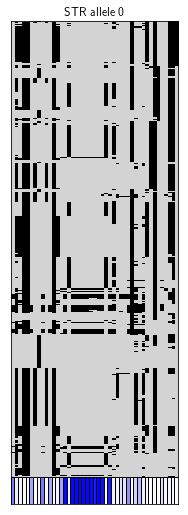

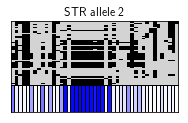

In [23]:
def PlotHapmaptrix(hapmatrix, ar2, allele, allsnps, fname):
    box_w =  1.0/len(allsnps)
    box_h = box_w
    hap_height = hapmatrix.shape[0]*0.0025
    legend_height = 0.5
    fig = plt.figure()
    fig.set_size_inches(3, hap_height + legend_height)
    gs = gridspec.GridSpec(2, 1, height_ratios=[hap_height, legend_height]) # TODO so bar same height always
    ax = fig.add_subplot(gs[0])
    # Plot SNPs
    imx = ax.imshow(hapmatrix, cmap=plt.cm.Greys.from_list("snp", ["lightgray","black"]), 
              aspect="auto", extent=(0, hapmatrix.shape[1], box_h, hapmatrix.shape[0]-box_h))
    ax2 = fig.add_subplot(gs[1])
    # Plot snp allele r2
    cm = plt.cm.Blues.from_list("freq",["white","blue"])
    patches = []
    colors = []
    for i in range(len(allsnps)):
        r2 = ar2[(ar2["pos"] == allsnps[i]) & (ar2["allele"]==allele)]["r2"].values[0]
        x = i*box_w
        y = 0
        rect = mpatches.Rectangle([x, y], box_w, box_h)
        patches.append(rect)
        colors.append(cm(r2))
    collection = PatchCollection(patches, color=colors, edgecolor="black")
    ax2.add_collection(collection)

    ax.set_yticks([]);
    ax.set_yticklabels([]);
    ax.set_xticks([]);
    ax.set_xticklabels([]);
    ax2.set_ylim(bottom=0, top=box_h)
    ax2.set_yticks([]);
    ax2.set_yticklabels([]);
    ax2.set_xticks([]);
    ax2.set_xticklabels([]);
    ax.set_title("STR allele %s"%allele)
    fig.subplots_adjust(hspace=0)
    fig.savefig(fname)
    
for allele in str_allele_lengths:
    hapmatrix = np.matrix(haplotype_filt[haplotype_filt["STR"]==allele][allsnps])
    if hapmatrix.shape[0]>= 10:
        print("%s:%s"%(allele, hapmatrix.shape))
        fname = os.path.join(OUTPATH, "%s_Example%s.pdf"%(PREFIX, allele))
        PlotHapmaptrix(hapmatrix, ar2, allele, allsnps, fname)

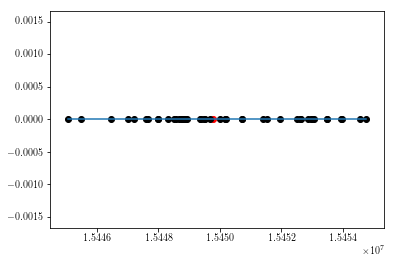

In [24]:
snppos = [int(item[3:]) for item in allsnps]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([min(snppos), max(snppos)], [0, 0])
ax.scatter([START],[0], color="red") # STR
for item in snppos:
    ax.scatter([item], [0], color="black") # SNPs
fig.savefig(os.path.join(OUTPATH, "%s_ExamplePositions.pdf"%PREFIX))